In [51]:
import geopandas as gpd
import pandas as pd
import geemap
import ee
import shapely
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
import json
import numpy as np

from PIL import Image

import geojson

import shapely
import rasterio as rio
from rasterio.plot import show, reshape_as_image
import rasterio.mask
from shapely.geometry import box

import matplotlib.colors as cl
import eeconvert as eec

import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

In [52]:
ee.Authenticate()
ee.Initialize()

Planificación General: Medir área total de la laguna a lo largo del tiempo -> hacer un área total del uso de suelo usando aquella red neuronal que clasificaba segun crop o algo asi -> Ver como avanzó crop e industrial a lo largo del tiempo.

### Definimos como aoi un área de aproximadamente 5km alrededor de la Laguna de Aculeo, y el intervalo de tiempo de interés 2014-2024 ya que se secó alrededor de 2018, Además de la disponibilidad de landsat 8, que comienza en 2013

# Definición de AOI, DOI

In [53]:
doi = ["2014-01-01","2024-01-01"] # Dates of interest?
doi_intervalar = [] # Se crean intervalos de un mes, para poder dividir las imágenes
for i in range(14,25): 
    for j in range(1,13):
        if i == 24 and j >= 6:
            break
        doi_intervalar.append(str(2000+i)+ "-" +  str(j)+ "-01")
doi_intervalar

['2014-1-01',
 '2014-2-01',
 '2014-3-01',
 '2014-4-01',
 '2014-5-01',
 '2014-6-01',
 '2014-7-01',
 '2014-8-01',
 '2014-9-01',
 '2014-10-01',
 '2014-11-01',
 '2014-12-01',
 '2015-1-01',
 '2015-2-01',
 '2015-3-01',
 '2015-4-01',
 '2015-5-01',
 '2015-6-01',
 '2015-7-01',
 '2015-8-01',
 '2015-9-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2016-1-01',
 '2016-2-01',
 '2016-3-01',
 '2016-4-01',
 '2016-5-01',
 '2016-6-01',
 '2016-7-01',
 '2016-8-01',
 '2016-9-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-1-01',
 '2017-2-01',
 '2017-3-01',
 '2017-4-01',
 '2017-5-01',
 '2017-6-01',
 '2017-7-01',
 '2017-8-01',
 '2017-9-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-1-01',
 '2018-2-01',
 '2018-3-01',
 '2018-4-01',
 '2018-5-01',
 '2018-6-01',
 '2018-7-01',
 '2018-8-01',
 '2018-9-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-1-01',
 '2019-2-01',
 '2019-3-01',
 '2019-4-01',
 '2019-5-01',
 '2019-6-01',
 '2019-7-01',
 '2019-8-01',
 '2019-9-01',
 '2019-10-01',
 '20

In [54]:
ee.Geometry.Point([-70.91725911612781,-33.84565081436696]).buffer(5000).area().getInfo()

77601512.35539426

In [55]:
aoi = ee.Geometry.Point([-70.91725911612781,-33.84565081436696]).buffer(5000)

m = geemap.Map(center=[-33.84565081436696, -70.91725911612781], zoom=15)

m.addLayer(aoi,name='aoi')
m

Map(center=[-33.84565081436696, -70.91725911612781], controls=(WidgetControl(options=['position', 'transparent…

In [56]:
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True)

# Análisis del área de la Laguna Aculeo

### Calculamos el NDWI para cada mes, conservando las fechas que tienen imágenes en condiciones para posteriormente armar el dataframe

In [57]:
# NDWI usado: http://archive.eclass.uth.gr/eclass/modules/document/file.php/MHXC241/PROJECT/Mc_Feeters_NDWI_01431169608948714.pdf

imagenes_ndwi = []
fechas_con_imagen = []
for i in tqdm(range(len(doi_intervalar)-1), total=len(doi_intervalar)-1):
    inicio = doi_intervalar[i]
    fin = doi_intervalar[i+1]
    print(inicio, fin)
    
# Obtenemos imágenes
    
    landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lessThan(leftField="CLOUD_COVER_LAND", rightValue=20)).filterDate(inicio,fin).filterBounds(aoi).select(['SR_B3', 'SR_B5'])
# Hacemos escalamientos correspondientes
    
    landsat_collection = landsat_collection.map(apply_scale_factors)
# Obtenemos geomediana para reducir a una imágen
    
    try: # Si no hay ninguna imágen para ese mes, esta siguiente linea dará error, por lo que esta linea lo maneja (de forma un poco bruta, pero funciona)
        r = ee.Reducer.geometricMedian(2).setOutputs(["geom_" + nombre for nombre in landsat_collection.first().bandNames().getInfo()])
    except:
        print("Colección Vacía")
        continue
    geomediana = landsat_collection.reduce(r)
#Calculamos ndwi
    ndwi = geomediana.normalizedDifference(["geom_SR_B3","geom_SR_B5"])
    geomediana = geomediana.addBands(ndwi)
# Agregamos a la lista
    imagenes_ndwi.append(geomediana)
    fechas_con_imagen.append(inicio) # Guardamos las fechas para después

ndwis = ee.ImageCollection.fromImages(imagenes_ndwi)




  0%|          | 0/124 [00:00<?, ?it/s]

2014-1-01 2014-2-01
2014-2-01 2014-3-01
2014-3-01 2014-4-01
Colección Vacía
2014-4-01 2014-5-01
2014-5-01 2014-6-01
Colección Vacía
2014-6-01 2014-7-01
2014-7-01 2014-8-01
Colección Vacía
2014-8-01 2014-9-01
2014-9-01 2014-10-01
Colección Vacía
2014-10-01 2014-11-01
2014-11-01 2014-12-01
2014-12-01 2015-1-01
Colección Vacía
2015-1-01 2015-2-01
2015-2-01 2015-3-01
2015-3-01 2015-4-01
2015-4-01 2015-5-01
2015-5-01 2015-6-01
2015-6-01 2015-7-01
Colección Vacía
2015-7-01 2015-8-01
2015-8-01 2015-9-01
Colección Vacía
2015-9-01 2015-10-01
Colección Vacía
2015-10-01 2015-11-01
2015-11-01 2015-12-01
2015-12-01 2016-1-01
2016-1-01 2016-2-01
2016-2-01 2016-3-01
Colección Vacía
2016-3-01 2016-4-01
2016-4-01 2016-5-01
2016-5-01 2016-6-01
2016-6-01 2016-7-01
2016-7-01 2016-8-01
Colección Vacía
2016-8-01 2016-9-01
2016-9-01 2016-10-01
2016-10-01 2016-11-01
2016-11-01 2016-12-01
2016-12-01 2017-1-01
Colección Vacía
2017-1-01 2017-2-01
2017-2-01 2017-3-01
2017-3-01 2017-4-01
2017-4-01 2017-5-01
Colecc

### Exportamos un video time-lapse del nivel de agua de la Laguna

In [58]:
videoArgs = {'dimensions': 500,
             'region': aoi,
             'framesPerSecond': 5,
            'bands': ["nd"], "palette":["green", "blue"]}

## Cambios: Mejor calcular todas los ndwi y hacer un video de eso yo creo
print(ndwis.getVideoThumbURL(videoArgs))

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/videoThumbnails/ba32b6c238bb0aa0545a52a67d681e31-196d92447c24bd8fb9e6c4e267ed7bd4:getPixels


### Casualmente se obtuvo 100 imaǵenes de meses tales que tuvieron al menos una imágen con una cobertura aceptable de nubes, para la que se calculó la geomediana de las bandas, y luego se computó el ndwi, ahora se busca obtener el area total de agua para cada imágen.

In [59]:
imagenes_binarias = [] #Imágenes binarias con píxeles diciendo si ese pixel tiene o no agua
for ndwi in imagenes_ndwi: # ndwi es una imágen que contiene 3 bandas, siendo una de estas ndwi
    imagenes_binarias.append(ndwi.gt(0.3).selfMask()) # Guardamos las imágenes de forma binaria

imagenes_binarias[0]

In [60]:
m = geemap.Map(center=[-33.84565081436696, -70.91725911612781], zoom=15)
vis = {
    'bands': ['nd']
}


m.addLayer(aoi,name='aoi')
m.addLayer(imagenes_binarias[0].clip(aoi), vis,name='agua')

m

Map(center=[-33.84565081436696, -70.91725911612781], controls=(WidgetControl(options=['position', 'transparent…

In [61]:
# Este segmento de código saca el área para cada imágen
areas = []
for imagen_binaria in imagenes_binarias:
    pixelarea = ee.Image.pixelArea()
    flood_extent2 = pixelarea.updateMask(imagen_binaria.select("nd"))
    suma = flood_extent2.reduceRegion(ee.Reducer.sum(), aoi, scale=30)
    suma = suma.getNumber('area').getInfo()# en metros cuadrados
    square_meters = suma
    square_kilometers = square_meters / (1e6)
    areas.append((square_meters,square_kilometers))

areas[0:5]
    

[(5646227.292114258, 5.646227292114258),
 (7319313.66809082, 7.31931366809082),
 (5105671.21484375, 5.10567121484375),
 (7210462.703491211, 7.210462703491211),
 (7162003.768676758, 7.162003768676758)]

### Se arma el dataframe con las áreas a través del tiempo

In [62]:
df = pd.DataFrame(areas, columns=["m", "km"])
df["fecha"] = fechas_con_imagen
df["año"] = df["fecha"].map(lambda x: (x.split("-")[0]))
df["mes"] = df["fecha"].map(lambda x: (x.split("-")[1]))
df["fecha"] = pd.to_datetime(df["fecha"])
df

,m,km,fecha,año,mes
0,5.646227e+06,5.646227,2014-01-01,2014,1
1,7.319314e+06,7.319314,2014-02-01,2014,2
2,5.105671e+06,5.105671,2014-04-01,2014,4
3,7.210463e+06,7.210463,2014-06-01,2014,6
4,7.162004e+06,7.162004,2014-08-01,2014,8
...,...,...,...,...,...
95,5.040128e+06,5.040128,2023-12-01,2023,12
96,4.727712e+06,4.727712,2024-01-01,2024,1
97,4.030591e+06,4.030591,2024-02-01,2024,2
98,2.138354e+06,2.138354,2024-03-01,2024,3


# Resultados área Laguna Aculeo

## Gráficos

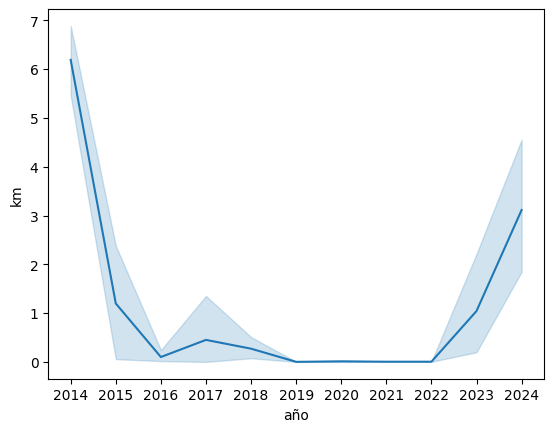

In [63]:
plot = sns.lineplot(y=df["km"], x=df["año"])
fig = plot.get_figure()
fig.savefig("visualizaciones/area_segun_tiempo.png") 

fig. 1 área de la laguna aculeo a lo largo del tiempo.

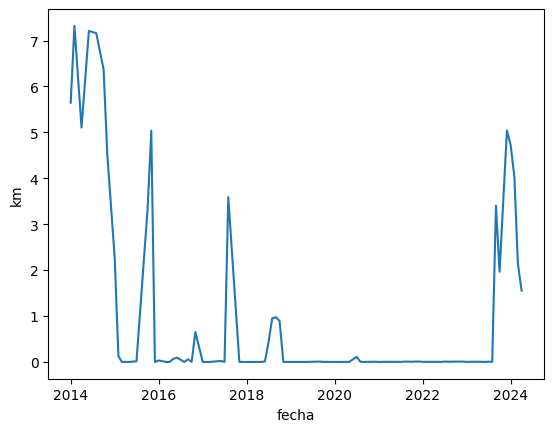

In [64]:

plot = sns.lineplot(y=df["km"], x=df["fecha"])
fig = plot.get_figure()
# fig.savefig("visualizaciones/area_segun_tiempo.png") 

Si lo ploteamos como fecha entera, las fluctuaciones generan _peaks_ muy grandes y cuesta un poco más interpretar el gráfico.

# Análisis Pluvial

In [65]:
lluvias = pd.read_csv("data/suma_anual_precip.csv")
lluvias.head()


,sum_precip,año
0,16.7,2019
1,48.8,2020
2,12.8,2021
3,116.0,2022
4,347.8,2023


### Lamentablemente, no existen muchas estaciones de medición pluvial, por lo que no hay mucho más que hacerle que tomar el dato de la más cercana: La estación El Paico. 

En caso de haber más estaciones en los alrededores se podría haber hecho una interpolación espacial para obtener datos más precisos, pero no fue el caso.  

<Axes: xlabel='año', ylabel='sum_precip'>

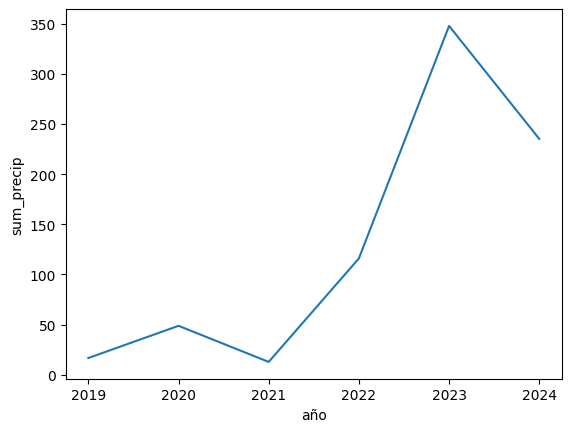

In [66]:
sns.lineplot(lluvias,x="año",y="sum_precip")

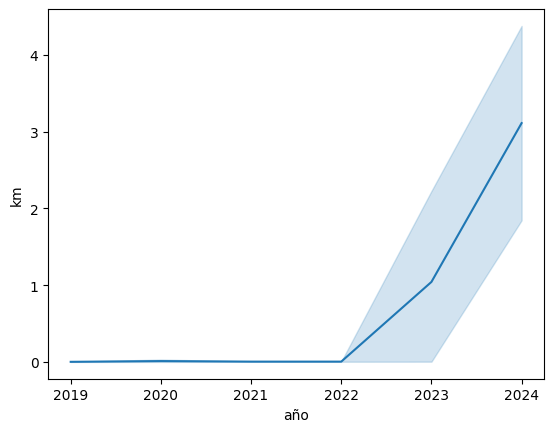

In [67]:
df_p = df.astype({"año":int})
df_p = df_p[df_p["año"] >= 2019] #Acotamos el dataframe del área de la laguna aculeo para compararlo con los datos de lluvias

plot = sns.lineplot(y=df_p["km"], x=df_p["año"])

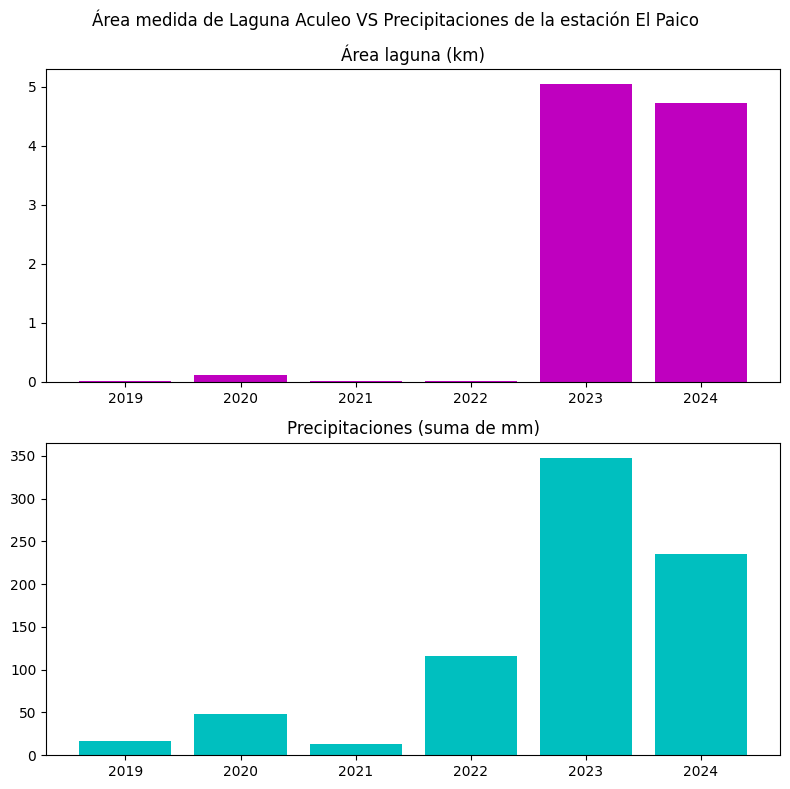

In [68]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].ticklabel_format(style='plain')
ax[0].set_title("Área laguna (km)")
ax[1].set_title("Precipitaciones (suma de mm)")
ax[0].bar(df_p["año"], df_p["km"], color='m')
ax[1].bar(lluvias["año"],lluvias["sum_precip"] , color='c')
fig.suptitle(f"Área medida de Laguna Aculeo VS Precipitaciones de la estación El Paico")
fig.tight_layout()
plt.savefig(f"visualizaciones/arealagunavsprecip.jpg", dpi="figure", format="jpg")

fig. 2 Área medida de Laguna Aculeo VS Precipitaciones de la estación El Paico

### Dada la limitación del _scope_ de este análisis, tales como que hay meses sin datos en precipitaciones, y meses sin datos satelitales, sólo podemos hacer el análisis de forma anual, de todas maneras se encuentra una suerte de correlación entre la lluvia y el área, verificando la hipótesis de que la laguna se secó dada la sequía que se está viviendo.

### Ahora se repetirá el proceso de recopilar imágenes, para obtener en esta ocasión imágenes RGB y aplicar el modelo 

# Uso de Redes Neuronales Convolucionales para predecir área de cultivo cercana

In [69]:
# Esta celda permite redefinir el aoi para cubrir mayor área al hacer la predicción de crop
aoi = ee.Geometry.Point([-70.91725911612781,-33.84565081436696]).buffer(8000)

m = geemap.Map(center=[-33.84565081436696, -70.91725911612781], zoom=15)

m.addLayer(aoi,name='aoi')
m

Map(center=[-33.84565081436696, -70.91725911612781], controls=(WidgetControl(options=['position', 'transparent…

In [70]:
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)#
  return image.addBands(optical_bands, None, True)#.addBands(thermal_bands, None, True)

In [71]:
imagenes = []
fechas_con_imagen = []
for i in range(len(doi_intervalar)-1):
    inicio = doi_intervalar[i]
    fin = doi_intervalar[i+1]
    print(inicio, fin)
    
# Obtenemos imágenes
    
    landsat_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lessThan(leftField="CLOUD_COVER_LAND", rightValue=20)).filterDate(inicio,fin).filterBounds(aoi).select(["SR_B4","SR_B3","SR_B2"])
    landsat_collection = landsat_collection.map(apply_scale_factors)
    # Exporta imagen
    
# Obtenemos geomediana para reducir a una imágen
    
    try: # Si no hay ninguna imágen para ese mes, esta siguiente linea dará error, por lo que esta linea lo maneja (de forma un poco bruta, pero funciona)
        r = ee.Reducer.geometricMedian(3).setOutputs(["geom_" + nombre for nombre in landsat_collection.first().bandNames().getInfo()])
    except:
        print("Colección Vacía")
        continue
    geomediana = landsat_collection.reduce(r)
    geomediana = geomediana.visualize(bands=['geom_SR_B4', 'geom_SR_B3', 'geom_SR_B2'], min=0.0, max=0.3)
# Agregamos a la lista
    #geemap.ee_export_image(geomediana, filename=f'test.tif', scale=30, region=aoi, file_per_band=False) # Exporta imagen
    imagenes.append(geomediana)
    fechas_con_imagen.append(inicio) # Guardamos las fechas para después


2014-1-01 2014-2-01
2014-2-01 2014-3-01
2014-3-01 2014-4-01
Colección Vacía
2014-4-01 2014-5-01
2014-5-01 2014-6-01
Colección Vacía
2014-6-01 2014-7-01
2014-7-01 2014-8-01
Colección Vacía
2014-8-01 2014-9-01
2014-9-01 2014-10-01
Colección Vacía
2014-10-01 2014-11-01
2014-11-01 2014-12-01
2014-12-01 2015-1-01
Colección Vacía
2015-1-01 2015-2-01
2015-2-01 2015-3-01
2015-3-01 2015-4-01
2015-4-01 2015-5-01
2015-5-01 2015-6-01
2015-6-01 2015-7-01
Colección Vacía
2015-7-01 2015-8-01
2015-8-01 2015-9-01
Colección Vacía
2015-9-01 2015-10-01
Colección Vacía
2015-10-01 2015-11-01
2015-11-01 2015-12-01
2015-12-01 2016-1-01
2016-1-01 2016-2-01
2016-2-01 2016-3-01
Colección Vacía
2016-3-01 2016-4-01
2016-4-01 2016-5-01
2016-5-01 2016-6-01
2016-6-01 2016-7-01
2016-7-01 2016-8-01
Colección Vacía
2016-8-01 2016-9-01
2016-9-01 2016-10-01
2016-10-01 2016-11-01
2016-11-01 2016-12-01
2016-12-01 2017-1-01
Colección Vacía
2017-1-01 2017-2-01
2017-2-01 2017-3-01
2017-3-01 2017-4-01
2017-4-01 2017-5-01
Colecc

In [72]:
image = imagenes[0].clip(aoi)
# Visualize map
Map = geemap.Map(zoom=16)
Map.addLayer(image,{} ,'Landsat 8')
Map.addLayerControl()
Map.centerObject(aoi)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [73]:
def generate_tiles(image_file, output_file, area_str, size=64): #código extraido del jupyter notebook que vimos en clase.
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)


### Se carga el modelo

In [74]:
!mkdir temp
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = 'recursos/best_resnet50_10.pth'

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

#cargar los parámetros del modelo
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

mkdir: cannot create directory ‘temp’: File exists
Model file recursos/best_resnet50_10.pth successfully loaded.


### Se generan los tiles

In [75]:
tiled_images = []
for image, fecha in zip(imagenes, fechas_con_imagen):
    image = image.clip(aoi).unmask() # Toma la imágen de un mes

    geemap.ee_export_image(image, filename=f'temp/aoi{fecha}.tif', scale=30, region=aoi, file_per_band=False) # Exporta imagen

    tif_file = f'temp/aoi{fecha}.tif' 

    img = rio.open(tif_file) #Se abre con rasterio
    
    output_file = 'temp/tiles.geojson'
    tiles = generate_tiles(tif_file, output_file, 'LagunaAculeo', size=64) # Se generan las tiles usando la funcion que vimos en un notebook
    tiled_images.append(tiles)
    print('Data dimensions: {}'.format(tiles.shape))
    #show_crop(tif_file, [tiles.iloc[23]['geometry']]) #Muestra un ejemplo

Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2014-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-5-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2015-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-5-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2016-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2017-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-5-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2018-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-5-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2019-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-5-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2020-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2021-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-11-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2022-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-6-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-7-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-8-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-9-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-10-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2023-12-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2024-1-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2024-2-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2024-3-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)
Generating URL ...
Please wait ...
Data downloaded to /home/cristobal/Universidad/proyecto2_geoespaciales/proyecto_geoespaciales/temp/aoi2024-4-01.tif


  0%|          | 0/342400 [00:00<?, ?it/s]

Data dimensions: (90, 2)


In [76]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        #print(out_image)
        try:
            out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
            ]
        except:
            pass

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })
        #print(out_image.min(),out_image.max())
        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp/temp.tif'
        with rasterio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        aaa = transform(image)
        output = model(aaa.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

In [77]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Se hacen las predicciones

In [78]:
!mkdir preds
for tiles, fecha in zip(tiled_images, fechas_con_imagen):
    labels = [] # Store predictions

# iteración sobre tiles
    tif_file = f'temp/aoi{fecha}.tif' 
    for index in tqdm(range(len(tiles)), total=len(tiles)):
        label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
        labels.append(label)

    tiles['pred'] = labels
# Cleanup temporary files

# Save predictions
    filepath = f"preds/{fecha}_preds.geojson"
    tiles.to_file(filepath, driver="GeoJSON")

mkdir: cannot create directory ‘preds’: File exists


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

### Se calcula el area total de cada imágen, es decir, de cada fecha.

In [79]:
areas_crop = []
for tiles, fecha in tqdm(zip(tiled_images, fechas_con_imagen), total=len(tiled_images)):
    #calcular área de   'AnnualCrop' y 'PermanentCrop' 
    bools = tiles.pred.map(lambda x: x == "AnnualCrop" or x == "PermanentCrop")
    tiles = tiles[bools]
    area = len(tiles)*(64**2)*30
    areas_crop.append(area)
    print(fecha,":",area)#64 pixeles cada bloque, cada pixel son 30m


  0%|          | 0/100 [00:00<?, ?it/s]

2014-1-01 : 860160
2014-2-01 : 983040
2014-4-01 : 860160
2014-6-01 : 122880
2014-8-01 : 245760
2014-10-01 : 491520
2014-11-01 : 737280
2015-1-01 : 737280
2015-2-01 : 737280
2015-3-01 : 614400
2015-4-01 : 368640
2015-5-01 : 368640
2015-7-01 : 491520
2015-10-01 : 245760
2015-11-01 : 737280
2015-12-01 : 860160
2016-1-01 : 983040
2016-3-01 : 368640
2016-4-01 : 368640
2016-5-01 : 122880
2016-6-01 : 122880
2016-8-01 : 614400
2016-9-01 : 245760
2016-10-01 : 1228800
2016-11-01 : 368640
2017-1-01 : 737280
2017-2-01 : 614400
2017-3-01 : 614400
2017-6-01 : 0
2017-7-01 : 491520
2017-8-01 : 122880
2017-11-01 : 614400
2017-12-01 : 737280
2018-1-01 : 614400
2018-2-01 : 614400
2018-3-01 : 491520
2018-4-01 : 614400
2018-5-01 : 860160
2018-6-01 : 245760
2018-7-01 : 122880
2018-8-01 : 245760
2018-9-01 : 491520
2018-10-01 : 245760
2018-11-01 : 491520
2018-12-01 : 983040
2019-1-01 : 737280
2019-2-01 : 860160
2019-3-01 : 983040
2019-5-01 : 614400
2019-6-01 : 491520
2019-8-01 : 368640
2019-9-01 : 491520
2019

### Se calcula el área total de crops, considerando ambos tipos de crop

In [80]:
df_crop = pd.DataFrame()
df_crop["area"] = areas_crop
df_crop["fecha"] = fechas_con_imagen
df_crop["año"] = df["fecha"].map(lambda x : x.year)
df_crop_a = df_crop.groupby(by="año")["area"].mean()


<Axes: xlabel='año', ylabel='area'>

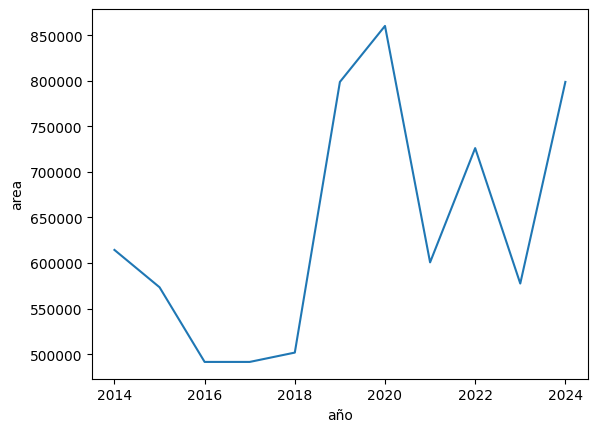

In [81]:
sns.lineplot(df_crop_a)

fig. 3 Área obtenida de crop a lo largo del tiempo

### Comprobamos como se categorizó los tiles

In [85]:
# Instantiate map centered on the centroid
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles = tiled_images[24]

tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)


map = folium.Map(location=[-33.84565081436696,-70.91725911612781],zoom_start=13)

folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

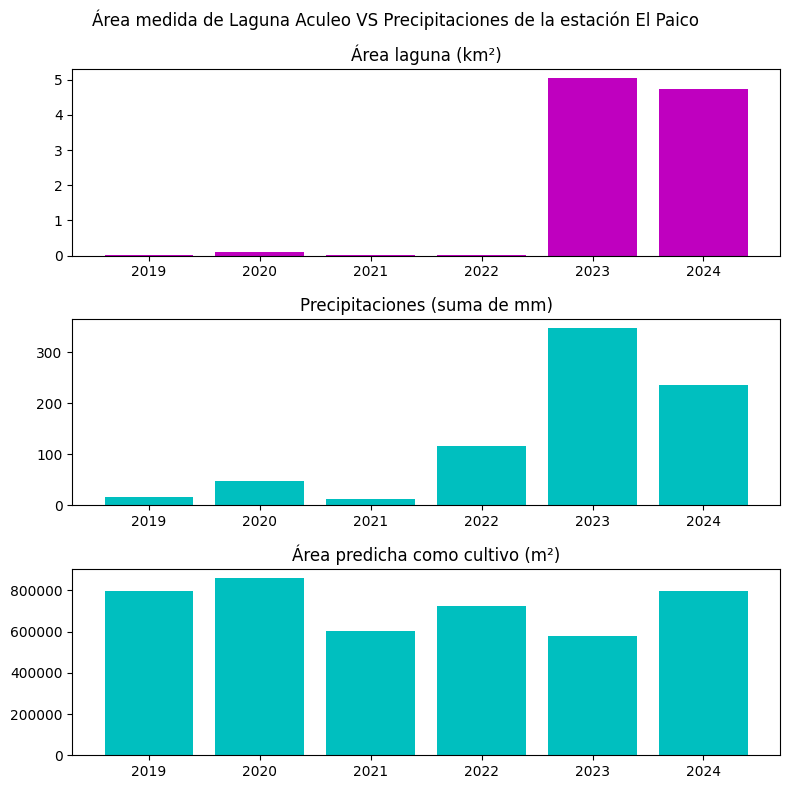

In [83]:
df_crop_a_19 = df_crop_a[df_crop_a.index >= 2019]
fig, ax = plt.subplots(3, figsize=(8,8))
ax[0].ticklabel_format(style='plain')
ax[0].set_title("Área laguna (km²)")
ax[1].set_title("Precipitaciones (suma de mm)")
ax[2].set_title("Área predicha como cultivo (m²)")
ax[0].bar(df_p["año"], df_p["km"], color='m')
ax[1].bar(lluvias["año"],lluvias["sum_precip"] , color='c')
ax[2].bar(df_crop_a_19.index,df_crop_a_19, color='c')
fig.suptitle(f"Área medida de Laguna Aculeo VS Precipitaciones de la estación El Paico")
fig.tight_layout()
plt.savefig(f"visualizaciones/arealaguna_precip_areacrop.jpg", dpi="figure", format="jpg")

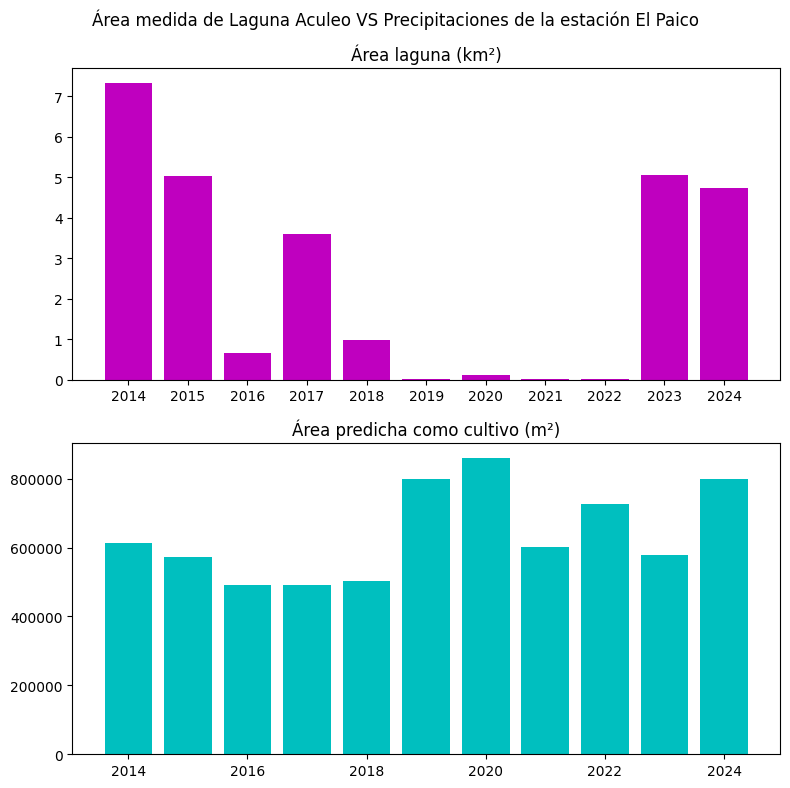

In [84]:
df_crop_a_19 = df_crop_a[df_crop_a.index >= 2019]
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].ticklabel_format(style='plain')
ax[0].set_title("Área laguna (km²)")
ax[1].set_title("Área predicha como cultivo (m²)")
ax[0].bar(df["año"], df["km"], color='m')
ax[1].bar(df_crop_a.index,df_crop_a, color='c')
fig.suptitle(f"Área medida de Laguna Aculeo VS Precipitaciones de la estación El Paico")
fig.tight_layout()
plt.savefig(f"visualizaciones/arealaguna_areacrop.jpg", dpi="figure", format="jpg")

fig. 4 Área predicha como cultivo vs Área de la Laguna Aculeo

### No hay correlación aparente entre las predicciones de cultivo y el área de la laguna.